##  Imports

In [831]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import warnings
import eurostat
import os

%matplotlib inline

In [832]:
from xgboost import XGBRegressor

In [833]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [834]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.datasets import make_hastie_10_2
from sklearn.preprocessing import PolynomialFeatures

In [835]:
sns.set_theme('notebook')
warnings.filterwarnings("ignore")

In [836]:
PATH = "clean_data/sweden_eurostat.csv"
RANDOM_STATE = 11

## Utils

In [837]:
def plot_dataframe(df: pd.DataFrame, n_cols: int = 4, plot: str = 'hist') -> None:
    """Plots numerical columns of a DataFrame as histograms or boxplots.

    Args:
        df (pd.DataFrame): Pandas DataFrame to plot.
        n_cols (int, optional): Number of columns for the plot layout. Defaults to 4.
        plot (str, optional): Type of plot to create ('hist' for histogram, 'box' for boxplot). Defaults to 'hist'.

    Returns:
        None
    """    
    num_cols = df.select_dtypes(include='number').columns
    n_rows = int(len(num_cols) / n_cols) + 1

    plots = ['hist', 'box']
    
    if plot not in plots:
        return print("Unknown plot option.")
    
    plt.figure(figsize=(20, 15))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        if plot == 'hist':
            sns.histplot(data=df, x=col, kde=True)
        elif plot == 'box':
            sns.boxplot(data=df, x=col)
        
        plt.title(col, fontsize=10)
        plt.tight_layout()

    plt.show()
    
    return None

In [838]:
def impute_missing_data(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Imputes missing data in a DataFrame.

    Args:
        raw_df (pd.DataFrame): Input DataFrame with missing values.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """    
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    df = df.set_index('TIME_PERIOD')
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        df[col] = df[col].interpolate(method='time', limit_direction='both').round(1)
    
    return df

In [839]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series, discrete_features: list) -> pd.Series:
    """Calculate mutual information scores for features in X with respect to target y.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.
        discrete_features (list): List of discrete feature names.

    Returns:
        pd.Series: Mutual information scores for each feature.
    """    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [840]:
def model_creation(numerical_cols: list, categorical_cols: list, model, poly: bool = False, poly_degree: int = 2, folds: int = 6, scaler: str = 'standard') -> tuple:
    """Create a machine learning model pipeline with preprocessing.

    Args:
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.
        model (_type_): Model to be used in the pipeline.
        poly (bool, optional): Boolean to use polynomial features or not.
        poly_degree (int, optional): Number of degree for the polynomial features.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        scaler (str, optional): Type of scaler to use. Defaults to 'standard'.

    Returns:
        tuple: A tuple containing the model pipeline and cross-validation strategy.
    """    
    if scaler == 'standard':
        scaler_transformer = StandardScaler()
    elif scaler == 'minmax':
        scaler_transformer = MinMaxScaler()
    elif scaler == 'robust':
        scaler_transformer = RobustScaler()
    else:
        scaler_transformer = 'passthrough'
    
    if poly:
        numerical_transformer = Pipeline(steps=[
            ('scaler', scaler_transformer),
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))
        ])
    else:
        numerical_transformer = Pipeline(steps=[
            ('scaler', scaler_transformer)
        ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    reg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    cv = KFold(n_splits=(folds - 1), shuffle=True, random_state=RANDOM_STATE)
    
    return reg, cv

In [841]:
def cross_validation(reg: Pipeline, X_train: pd.DataFrame, y_train: pd.Series, method: str, splits: int = 5) -> None:
    """Perform cross-validation for the given regression model.

    Args:
        reg (Pipeline): Regression model pipeline.
        X_train (pd.DataFrame): Training feature DataFrame.
        y_train (pd.Series): Training target variable.
        method (str): Scoring method.
        splits (int, optional): Number of splits for TimeSeriesSplit. Defaults to 5.

    Returns:
        None
    """
    tscv = TimeSeriesSplit(n_splits=splits)
    scores = cross_val_score(reg, X_train, y_train, cv=tscv, scoring=method)

    if method.startswith("neg_"):
        scores = -scores

    is_percentage = any(keyword in method.lower() for keyword in ["r2", "accuracy", "score"])

    print(f"\nCross-validation results ({method}):")
    for i, s in enumerate(scores, start=1):
        if is_percentage:
            print(f"Fold {i}: {s*100:.2f}%")
        else:
            print(f"Fold {i}: {s:.5f}")

    if is_percentage:
        print(f"Average {method}: {np.mean(scores)*100:.2f}%")
    else:
        print(f"Average {method}: {np.mean(scores):.5f}")

    return None

In [842]:
def model_acc(y_test: pd.Series, y_pred: pd.Series, model_name: str = "Regression Model") -> None:
    """Evaluate the performance of a regression model.

    Args:
        y_test (pd.Series): True target values.
        y_pred (pd.Series): Predicted target values.
        model_name (str, optional): Name of the model being evaluated. Defaults to "Regression Model".

    Returns:
        None
    """    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    print(f"Model - {model_name}")
    print(f"R² Score: {r2:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5f}")
    if mape < 50:
        print(f"MAPE: {mape:.2f}%")
    else:
        print(f"MAPE score is unreliable.")
    
    return None

In [843]:
def train_and_evaluate(
        X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series,
        numerical_cols: list, categorical_cols: list, model_dict: dict, poly: bool = False,
        folds: int = 6, selection_metric: str = 'Test R²'
) -> tuple:
    """Train and evaluate multiple regression models.

    Args:
        X_train (pd.DataFrame): Training feature DataFrame.
        X_test (pd.DataFrame): Testing feature DataFrame.
        y_train (pd.Series): Training target variable.
        y_test (pd.Series): Testing target variable.
        numerical_cols (list): Numerical column names.
        categorical_cols (list): Categorical column names.
        model_dict (dict): Dictionary of model names and their corresponding model instances.
        poly (bool, optional): Boolean to specify if to use polynomial features or not.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        selection_metric (str, optional): Metric used for model selection. Defaults to 'Test R²'.

    Returns:
        tuple: A tuple containing the results DataFrame, the best model name, the best model instance, the predictions dictionary, and the trained models dictionary.
    """     
    results = []
    predictions = {}
    models_trained = {}
    best_model = None
    best_name = None
    best_score = -float('inf')
    
    for name, model in model_dict.items():
        print(f"\n--- Training {name} ---")
        reg, cv = model_creation(numerical_cols, categorical_cols, model, folds=folds, poly=poly)

        cross_validation(reg, X_train, y_train, method='neg_root_mean_squared_error')

        reg.fit(X_train, y_train)

        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)

        # Collect metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        metrics = {
            "Model": name,
            "Train R²": r2_score(y_train, y_pred_train),
            "Test R²": r2_score(y_test, y_pred_test),
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_test),
            "Train RMSE": float(np.sqrt(train_mse)),
            "Test RMSE": float(np.sqrt(test_mse)),
        }
        results.append(metrics)

        # Store predictions
        predictions[name] = {
            'y_train_pred': y_pred_train,
            'y_test_pred': y_pred_test
        }

        # Store trained model
        models_trained[name] = reg

        # Update best model
        if selection_metric in metrics and metrics[selection_metric] > best_score:
            best_score = metrics[selection_metric]
            best_model = reg
            best_name = name

    results_df = pd.DataFrame(results)
    return results_df, best_name, best_model, predictions, models_trained

In [844]:
def parameter_tuning(
        name: str, regressor, param_grid: dict,
        numerical_cols: list, categorical_cols: list,
        X_train: pd.DataFrame, y_train: pd.Series,
        refit: str = 'rmse',
        cv: int = 5, n_jobs: int = -1
) -> None:
    """Tune hyperparameters for a regression model using grid search.

    Args:
            name (str): Name of the model.
            regressor (_type_): Regressor model instance.
            param_grid (dict): Dictionary of hyperparameters to tune.
            numerical_cols (list): Numerical column names.
            categorical_cols (list): Categorical column names.
            X_train (pd.DataFrame): Training feature DataFrame.
            y_train (pd.Series): Training target variable.
            refit (str, optional): Type of score for which to improve the search.
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            n_jobs (int, optional): Number of jobs to run in parallel. Defaults to -1.

    Returns:
            None
    """
    scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error'}
    reg, cv = model_creation(numerical_cols, categorical_cols, regressor)
    param_grid = {f"model__{key}": value for key, value in param_grid.items()}
    grid_search = GridSearchCV(reg, param_grid, scoring=scoring, refit=refit, cv=cv, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    results = pd.DataFrame(grid_search.cv_results_)
    print(f"Model - {name}")
    print(grid_search.best_params_)
 
    return None

In [845]:
def train_test_time_series(df: pd.DataFrame, target_col: str) -> tuple:
    """Split the DataFrame into train and test sets for time series analysis.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_col (str): The name of the target column.

    Returns:
        tuple: A tuple containing X_train, X_test, y_train, y_test.
    """    
    split_point = int(len(df) * 0.8)
    train = df.iloc[:split_point]
    test = df.iloc[split_point:]

    X_train, y_train = train.drop(columns=[target_col]), train[target_col]
    X_test, y_test = test.drop(columns=[target_col]), test[target_col]

    return X_train, X_test, y_train, y_test

In [846]:
def add_lag_columns(df: pd.DataFrame, cols: list, lag: int = 1) -> pd.DataFrame:
    """Add lagged features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to add lagged features to.
        cols (list): Columns to create lagged features for.
        lag (int, optional): Number of periods to lag. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with added lagged features.
    """    
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

In [847]:
def get_feature_importance(estimator, all_features: list) -> pd.DataFrame:
    """Get feature importance from the trained model.

    Args:
        estimator (_type_): Trained regression model.
        all_features (list): List of all feature names.

    Raises:
        AttributeError: Model has no feature importance or coefficients.

    Returns:
        pd.DataFrame: DataFrame containing features and their importance.
    """    
    # Tree-based model
    if hasattr(estimator, "feature_importances_"):
        importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False)

    # Linear model
    elif hasattr(estimator, "coef_"):
        importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': np.abs(estimator.coef_)  # use absolute value for interpretability
        }).sort_values(by='Importance', ascending=False)

    else:
        raise AttributeError(f"Model {type(estimator).__name__} has no feature importance or coefficients.")

    return importance_df


In [848]:
def moving_average(df, window):
    return df.rolling(window=window).mean()

def exp_smoothing(df, alpha=0.3):
    return df.ewm(alpha=alpha).mean()

# Hodrick-Prescott Filter
def hp_filter(df, lambda_param=1600):  # 1600 is standard for quarterly data
    cycle, trend = hpfilter(df, lambda_param)
    return trend, cycle

In [849]:
def compute_vif(subset: pd.DataFrame) -> pd.DataFrame:
    clean_df = pd.DataFrame()
    clean_df = subset.dropna()
    clean_df = add_constant(clean_df)

    vif_df = pd.DataFrame()
    vif_df['features'] = clean_df.columns # pyright: ignore[reportAttributeAccessIssue]
    vif_df['VIF'] = [variance_inflation_factor(clean_df.values, i) for i in range(clean_df.shape[1])] # pyright: ignore[reportAttributeAccessIssue]

    vif_df.sort_values(by="VIF", ascending=False)
    
    return vif_df

In [850]:
def add_time_series_features(df: pd.DataFrame, target_cols, rolling_windows, ewm_alphas, lags=[1]):
    df = df.copy()
    
    for col in target_cols:
        for lag in lags:
            df[f"{col}_lag"] = df[col].shift(lag)
        
        if col in rolling_windows:
            window = rolling_windows[col]
            df[f"{col}_ma"] = df[col].shift(1).rolling(window=window).mean()
        
        if col in ewm_alphas:
            alpha = ewm_alphas[col]
            df[f"{col}_ewm"] = df[col].shift(1).ewm(alpha=alpha, adjust=False).mean()
    
    return df

In [851]:
def compute_heatmap(df: pd.DataFrame) -> None:
    num_df = df.select_dtypes(include='number')
    corr_data = num_df.corr()

    plt.figure(figsize=(10, 7))
    sns.heatmap(data=corr_data, annot=False)
    plt.title("Correlation Heatmap")
    plt.show()
    
    return None

In [852]:
models_tuning = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(random_state=RANDOM_STATE),
    "LassoRegression": Lasso(random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_STATE),
    # "XGBoost": XGBRegressor(random_state=RANDOM_STATE)
}

param_grids = {
    "LinearRegression": {
        "fit_intercept": [True, False],
        "positive": [False, True]
    },
    "RidgeRegression": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "solver": ["auto", "svd", "cholesky", "sparse_cg", "lsqr"],
        "fit_intercept": [True, False],
    },
    "LassoRegression": {
        "alpha": [0.001, 0.01, 0.1, 1.0],
        "max_iter": [5000, 10000, 20000],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"],
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 20],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt"],
    },
    # "XGBoost": {
    #     "n_estimators": [50, 100, 200],
    #     "max_depth": [2, 3, 7],
    #     "learning_rate": [0.01, 0.2],
    #     "subsample": [0.7, 1.0],
    #     "colsample_bytree": [0.7, 1.0],
    #     "gamma": [0, 0.3],
    #     "reg_alpha": [0, 1],
    #     "reg_lambda": [1, 5],
    #     "min_child_weight": [1, 5],
    #     "tree_method": ["hist"],
    #     "verbosity": [0]
    # }
}

## Load Dataset

In [853]:
df = pd.read_csv(PATH)

df.head()

,TIME_PERIOD,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
0,2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
1,2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2,2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
3,2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
4,2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [854]:
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
df = df.set_index('TIME_PERIOD')

In [855]:
# Renaming columns for easier access
df = df.rename(columns={
    'gdp_quarterly': 'gdp',
    'inflation_rate_monthly_m': 'inflation_rate_monthly',
    'inflation_rate_monthly_y': 'inflation_rate',
    'total_unemployment_rate': 'unemployment_rate',
    'gdp_growth_rate_quarterly': 'gdp_growth_rate',
})

In [856]:
df.isnull().sum()

gdp                        206
education_attainment       284
gdp_per_capita             284
price_index                  0
energy_prices              272
inflation_rate_monthly       0
inflation_rate               0
gas_emissions              285
net_migration              284
total_population           284
net_population_growth      284
growth_rate                284
births                     284
deaths                     284
unemployment_rate            0
adult_unemployment_rate      0
youth_unemployment_rate      0
gdp_growth_rate            207
household_income           288
dtype: int64

## Model Creation

In [857]:
df.head()

,gdp,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly,inflation_rate,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate,household_income
TIME_PERIOD,,,,,,,,,,,,,,,,,,,
2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [858]:
numeric_cols = df.select_dtypes(include='number').columns
outliers_dict = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names='index_row')

outliers_df = outliers_df.drop(columns=['inflation_rate', 'inflation_rate_monthly', 'index_row'])
outliers_df = outliers_df.dropna(how='all')
outliers_df

,energy_prices,deaths,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate
0,NaN,NaN,NaN,NaN,2.9
1,NaN,NaN,NaN,9.6,NaN
2,NaN,NaN,NaN,9.6,NaN
3,NaN,NaN,NaN,9.9,NaN
4,NaN,NaN,NaN,9.8,NaN
6,NaN,NaN,NaN,NaN,-4.0
7,NaN,NaN,NaN,NaN,3.3
8,NaN,NaN,NaN,NaN,-2.9
13,NaN,98124.0,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,-8.6


In [859]:
df = df.drop(columns=['gdp_growth_rate'])

split_point = int(len(df) * 0.70)
train = df.iloc[:split_point].copy()
test  = df.iloc[split_point:].copy()

In [860]:
numeric_cols = train.select_dtypes(include='number').columns

for col in numeric_cols:
    train[col] = train[col].interpolate(method='time', limit_direction='forward').round(1)
    
for col in numeric_cols:
    test[col] = test[col].interpolate(method='time', limit_direction='forward').round(1)

train['gdp_growth_rate'] = train['gdp'].pct_change() * 100
test['gdp_growth_rate'] = test['gdp'].pct_change() * 100

In [861]:
# train['gdp_growth_rate'] = np.log1p(train['gdp_growth_rate'])
# test['gdp_growth_rate'] = np.log1p(test['gdp_growth_rate'])

# train['inflation_rate'] = np.log1p(train['inflation_rate'])
# test['inflation_rate'] = np.log1p(test['inflation_rate'])

In [862]:
target_cols = ["gdp_growth_rate", "inflation_rate", "unemployment_rate"]
rolling_windows = {"gdp_growth_rate": 3, "inflation_rate": 2, "unemployment_rate": 3}
ewm_alphas = {"gdp_growth_rate": 0.3, "inflation_rate": 0.3}

In [863]:
train = add_time_series_features(train, target_cols, rolling_windows, ewm_alphas)

# To avoid leakage, combine last few rows of train with test
lookback_rows = max(list(rolling_windows.values()) + [1])
combined = pd.concat([train.tail(lookback_rows), test])
combined = add_time_series_features(combined, target_cols, rolling_windows, ewm_alphas)
test = combined.iloc[lookback_rows:]

In [864]:
train = train.dropna()
test = test.dropna()

### Model 1 (GDP Growth)

In [865]:
target_col = 'gdp_growth_rate'

In [866]:
subset = train[[
    'gdp_per_capita', 
    'inflation_rate_monthly', 'unemployment_rate', 
    'gdp_growth_rate_lag', 'gdp_growth_rate_ma'
]]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,1533.146780
1,gdp_per_capita,1.319935
2,inflation_rate_monthly,1.038460
3,unemployment_rate,1.283117
4,gdp_growth_rate_lag,3.909542
5,gdp_growth_rate_ma,4.150176


In [867]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [868]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(15)

gdp_growth_rate_lag        1.280826
total_population           0.799505
education_attainment       0.739555
price_index                0.683508
net_migration              0.616751
gdp_per_capita             0.548332
household_income           0.526952
net_population_growth      0.520472
growth_rate                0.512595
births                     0.501724
gdp                        0.500785
gas_emissions              0.449859
deaths                     0.429029
adult_unemployment_rate    0.419939
unemployment_rate_ma       0.381131
Name: MI Scores, dtype: float64

In [869]:
drop_cols=[
    'inflation_rate', 
    'inflation_rate_lag_1', 
    'unemployment_rate_lag_1',
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    'unemployment_rate_ma',
    'gdp',
    # 'gdp_growth_rate_lag',
    # 'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    # 'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    'inflation_rate_m',
    'gas_emissions',
    'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    'inflation_rate_lag',
    'unemployment_rate_lag',
    # 'unemployment_rate',
    # 'inflation_rate_monthly'
]

In [870]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_per_capita', 'inflation_rate_monthly', 'unemployment_rate', 'gdp_growth_rate_lag', 'gdp_growth_rate_ma']


In [871]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], 
#                      value, numerical_cols, 
#                      categorical_cols, X_train, y_train, 
#                      refit='rmse')

In [872]:
# Best parameters
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=0.01, fit_intercept=True, solver='auto', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.001, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=200,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

In [873]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53594
Fold 2: 0.49766
Fold 3: 0.19750
Fold 4: 0.20743
Fold 5: 0.08675
Average neg_root_mean_squared_error: 0.30506

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53415
Fold 2: 0.49697
Fold 3: 0.19746
Fold 4: 0.20741
Fold 5: 0.08670
Average neg_root_mean_squared_error: 0.30454

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53158
Fold 2: 0.48636
Fold 3: 0.19513
Fold 4: 0.20640
Fold 5: 0.08296
Average neg_root_mean_squared_error: 0.30049

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.66222
Fold 2: 0.37915
Fold 3: 0.19198
Fold 4: 0.23212
Fold 5: 0.07768
Average neg_root_mean_squared_error: 0.30863

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.63588
Fold 2: 0.40168
Fold 3: 0.1785

In [874]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.629127,0.286906,0.138504,0.330545,0.233671,0.595541
1,RidgeRegression,0.629127,0.286931,0.138496,0.330507,0.233671,0.595531
2,LassoRegression,0.628975,0.290352,0.137409,0.324758,0.233719,0.594101
3,RandomForestRegressor,0.774001,0.204857,0.119486,0.325841,0.182409,0.628870
4,XGBoost,0.458021,0.010616,0.165004,0.381048,0.282477,0.701489


In [875]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp_growth_rate   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     42.75
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           1.42e-25
Time:                        16:14:13   Log-Likelihood:                 4.6071
No. Observations:                 132   AIC:                             2.786
Df Residuals:                     126   BIC:                             20.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1268      0.021      6.090      0.0

In [876]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
3     gdp_growth_rate_lag    0.343253
4      gdp_growth_rate_ma    0.112728
2       unemployment_rate    0.079853
0          gdp_per_capita    0.055411
1  inflation_rate_monthly    0.004230


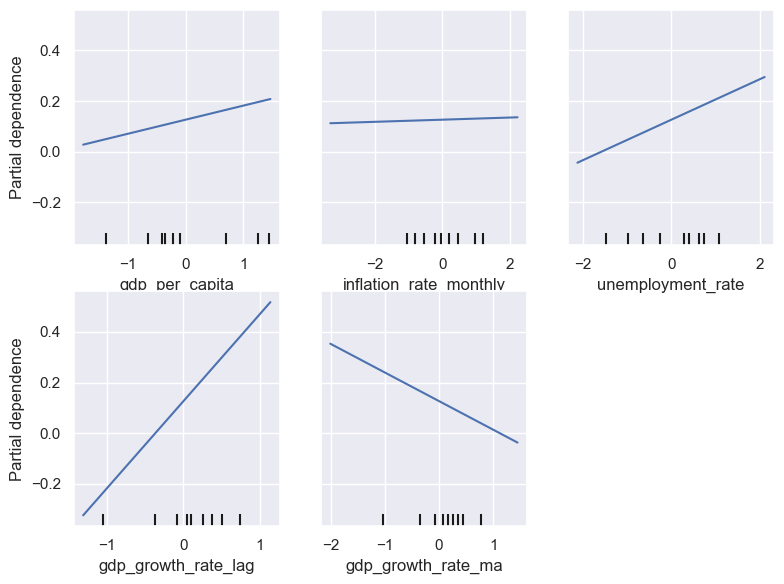

In [877]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
# plt.figure(figsize=(14, 8))
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [878]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred, 'Actual': y_test})

In [879]:
residuals_df.tail()

,Residuals,Predicted,Actual
TIME_PERIOD,,,
2025-05-01,-0.116390,0.468609,0.352219
2025-06-01,-0.147288,0.509962,0.362674
2025-07-01,-0.202242,0.551957,0.349714
2025-08-01,-0.509436,0.509436,0.000000
2025-09-01,-0.231558,0.231558,0.000000


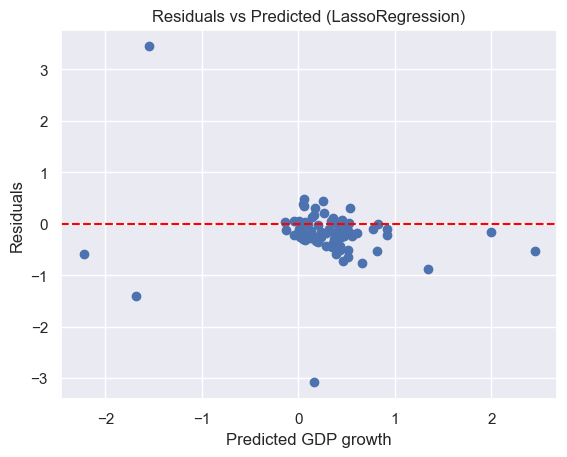

In [880]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

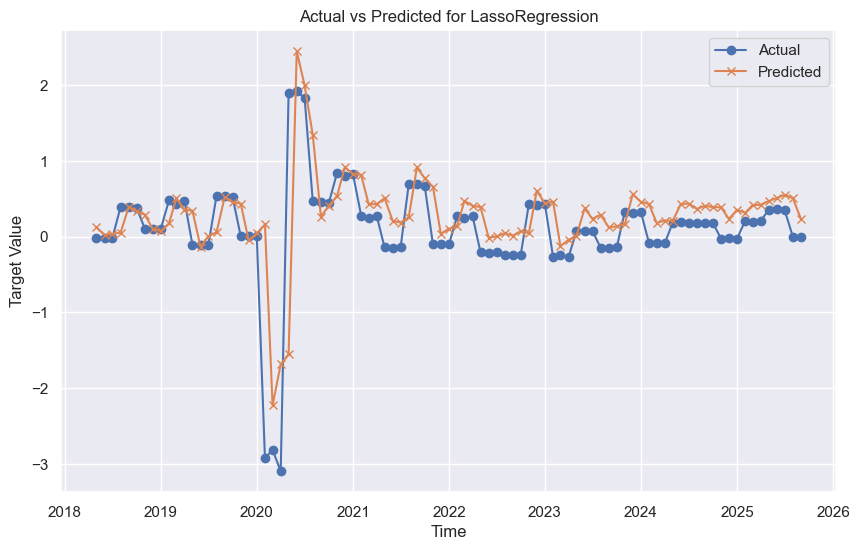

In [881]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()

### Model 2 (Inflation Rate)

In [882]:
target_col = 'inflation_rate'

In [883]:
subset = train[[
    'gdp_per_capita', 'inflation_rate_lag',
    'inflation_rate_monthly', 'unemployment_rate', 
    'gdp_growth_rate', 'gdp_growth_rate_ma'
]]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,2487.924978
1,gdp_per_capita,1.909036
2,inflation_rate_lag,1.780269
3,inflation_rate_monthly,1.028571
4,unemployment_rate,1.726417
5,gdp_growth_rate,1.719014
6,gdp_growth_rate_ma,1.753376


In [884]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [885]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(10)

inflation_rate_lag      1.041420
inflation_rate_ma       0.982914
total_population        0.920740
inflation_rate_ewm      0.895149
education_attainment    0.890358
price_index             0.868584
gas_emissions           0.810273
gdp_per_capita          0.802380
births                  0.755015
gdp                     0.721365
Name: MI Scores, dtype: float64

In [886]:
drop_cols=[ 
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    'unemployment_rate_ma',
    'gdp',
    # 'gdp_growth_rate',
    'gdp_growth_rate_lag',
    # 'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    # 'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    'gas_emissions',
    'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    # 'inflation_rate_lag',
    'unemployment_rate_lag',
    # 'unemployment_rate',
    # 'inflation_rate_monthly'
]

In [887]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_per_capita', 'inflation_rate_monthly', 'unemployment_rate', 'gdp_growth_rate', 'gdp_growth_rate_ma', 'inflation_rate_lag']


In [888]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], 
#                      value, numerical_cols, 
#                      categorical_cols, X_train, y_train, 
#                      refit='rmse')

In [889]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=1.0, fit_intercept=True, solver='lsqr', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.001, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

In [890]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.57542
Fold 2: 0.26275
Fold 3: 0.24957
Fold 4: 0.29334
Fold 5: 0.28381
Average neg_root_mean_squared_error: 0.33298

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.52940
Fold 2: 0.26853
Fold 3: 0.25074
Fold 4: 0.29487
Fold 5: 0.28967
Average neg_root_mean_squared_error: 0.32664

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.56358
Fold 2: 0.26508
Fold 3: 0.24973
Fold 4: 0.29203
Fold 5: 0.28290
Average neg_root_mean_squared_error: 0.33067

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.66108
Fold 2: 0.50881
Fold 3: 0.78944
Fold 4: 0.23972
Fold 5: 0.47985
Average neg_root_mean_squared_error: 0.53578

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.93331
Fold 2: 0.78303
Fold 3: 1.2272

In [891]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.910205,0.942518,0.222909,0.486392,0.272909,0.650892
1,RidgeRegression,0.910132,0.938390,0.223124,0.504462,0.273019,0.673859
2,LassoRegression,0.910194,0.943142,0.222892,0.483407,0.272925,0.647348
3,RandomForestRegressor,0.985840,-0.117456,0.089939,1.684916,0.108373,2.869844
4,XGBoost,0.697485,-0.128284,0.364676,1.724516,0.500915,2.883715


In [892]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     211.2
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           6.45e-63
Time:                        16:14:17   Log-Likelihood:                -15.882
No. Observations:                 132   AIC:                             45.76
Df Residuals:                     125   BIC:                             65.94
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4106      0.024     57.789      0.0

In [893]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
5      inflation_rate_lag    0.821080
1  inflation_rate_monthly    0.117559
2       unemployment_rate    0.066129
4      gdp_growth_rate_ma    0.059910
0          gdp_per_capita    0.033773
3         gdp_growth_rate    0.019855


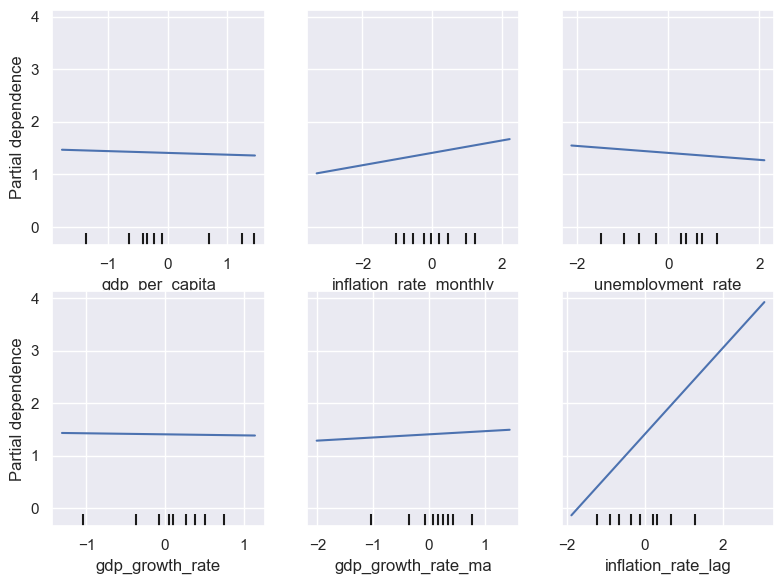

In [894]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [895]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred})

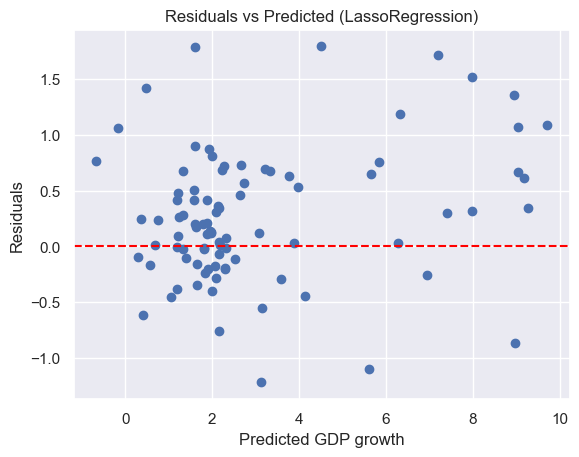

In [896]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

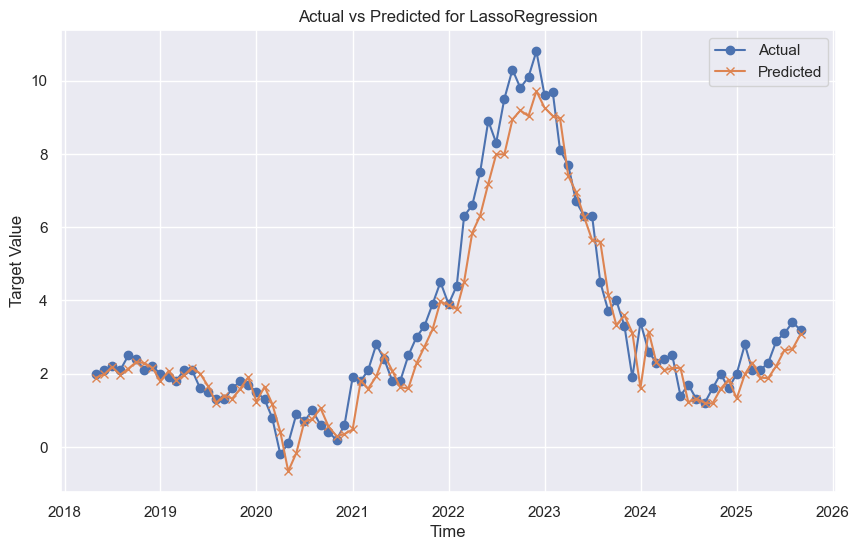

In [897]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()

### Model 3 (Unemployment Rate)

In [898]:
target_col = 'unemployment_rate'

In [899]:
subset = train[[
    'total_population',
    'inflation_rate_monthly', 
    'gdp_growth_rate', 'gdp_growth_rate_ma', 'unemployment_rate_ma'
]]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,1348.293199
1,total_population,1.049729
2,inflation_rate_monthly,1.036703
3,gdp_growth_rate,1.634356
4,gdp_growth_rate_ma,1.665123
5,unemployment_rate_ma,1.312791


In [900]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [901]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(10)

unemployment_rate_ma       1.183616
adult_unemployment_rate    1.178076
total_population           1.134322
education_attainment       1.127602
price_index                1.070951
youth_unemployment_rate    1.027325
gas_emissions              0.968218
unemployment_rate_lag      0.950654
births                     0.910835
gdp                        0.909851
Name: MI Scores, dtype: float64

In [902]:
drop_cols=[ 
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    'unemployment_rate_ma',
    'gdp',
    # 'gdp_growth_rate',
    'gdp_growth_rate_lag',
    # 'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    'inflation_rate_m',
    'gas_emissions',
    # 'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    'inflation_rate_lag',
    # 'unemployment_rate_lag',
    'gdp_growth_rate_lag',
    'inflation_rate',
    # 'inflation_rate_monthly'
]

In [903]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['inflation_rate_monthly', 'total_population', 'gdp_growth_rate', 'gdp_growth_rate_ma', 'unemployment_rate_lag']


In [904]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], 
#                      value, numerical_cols, 
#                      categorical_cols, X_train, y_train, 
#                      refit='rmse')

In [905]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=True),
    "RidgeRegression": Ridge(alpha=1.0, fit_intercept=True, solver='svd', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.01, fit_intercept=True, max_iter=20000, selection='random', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

In [906]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 1.45257
Fold 2: 0.74011
Fold 3: 0.20906
Fold 4: 0.32721
Fold 5: 0.31551
Average neg_root_mean_squared_error: 0.60889

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.09107
Fold 2: 0.79315
Fold 3: 0.22234
Fold 4: 0.32489
Fold 5: 0.31606
Average neg_root_mean_squared_error: 0.74950

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 1.99153
Fold 2: 0.67561
Fold 3: 0.19949
Fold 4: 0.30602
Fold 5: 0.31556
Average neg_root_mean_squared_error: 0.69764

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.38821
Fold 2: 0.62645
Fold 3: 0.23867
Fold 4: 0.48465
Fold 5: 0.42418
Average neg_root_mean_squared_error: 0.83243

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.40234
Fold 2: 0.26414
Fold 3: 0.5079

In [907]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.884314,0.714508,0.230068,0.369909,0.297022,0.485565
1,RidgeRegression,0.888743,0.702496,0.227064,0.376437,0.291281,0.495674
2,LassoRegression,0.887704,0.717211,0.227966,0.367899,0.292639,0.483261
3,RandomForestRegressor,0.986809,0.329422,0.074409,0.634292,0.100299,0.744174
4,XGBoost,0.733392,-0.075712,0.365760,0.797898,0.450907,0.942536


In [908]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     201.4
Date:                Thu, 06 Nov 2025   Prob (F-statistic):           2.60e-58
Time:                        16:14:20   Log-Likelihood:                -24.443
No. Observations:                 132   AIC:                             60.89
Df Residuals:                     126   BIC:                             78.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5568      0.026    291.301      0.0

In [909]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
4   unemployment_rate_lag    0.818118
3      gdp_growth_rate_ma    0.042408
2         gdp_growth_rate    0.028206
0  inflation_rate_monthly    0.020823
1        total_population    0.006284


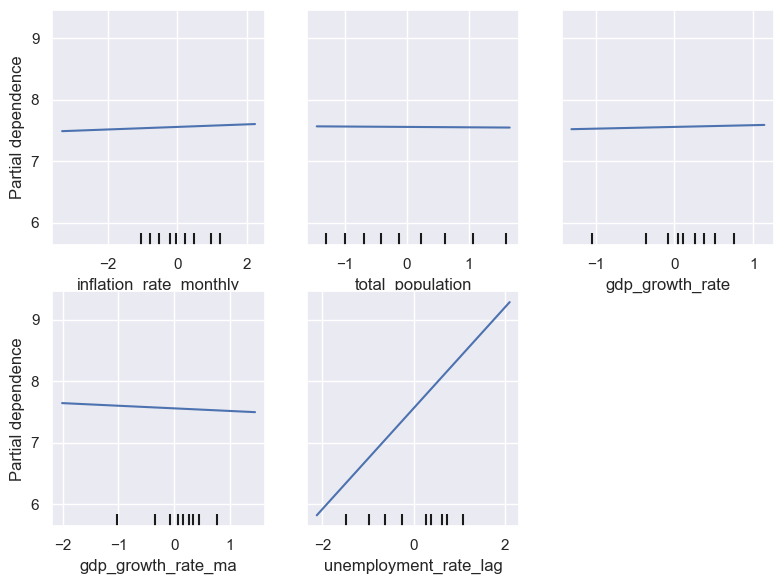

In [910]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [911]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred})

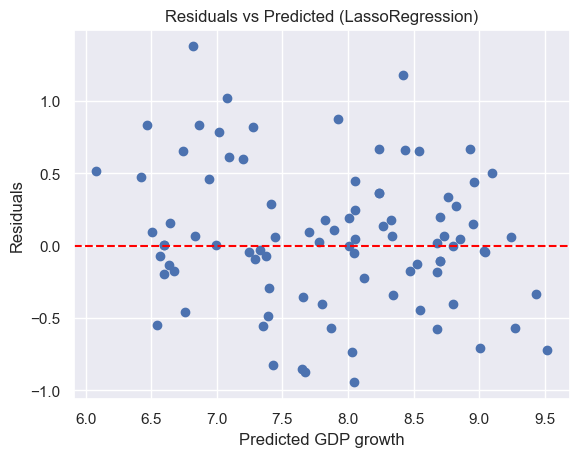

In [912]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

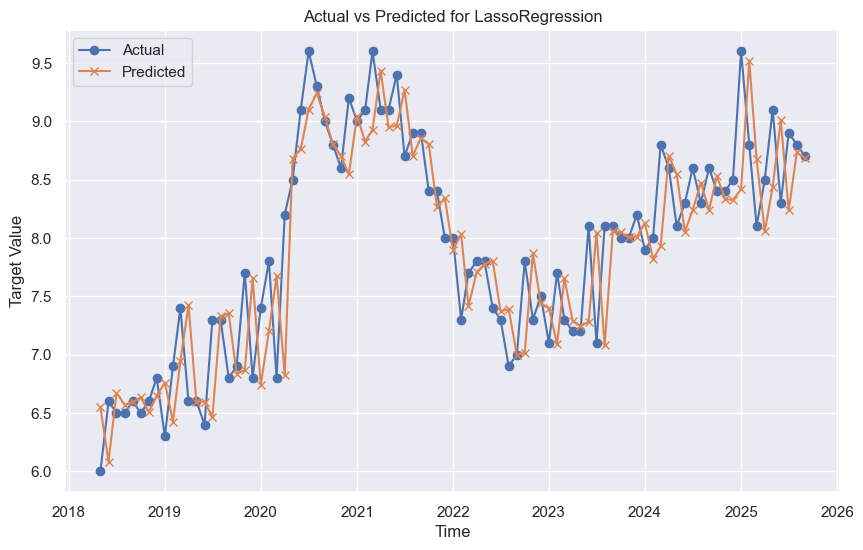

In [913]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()